In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from konlpy.tag import Mecab
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
%matplotlib inline
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

### 메뉴를 이용한 정보

In [6]:
#### 띄어쓰기 및 오타 수정
train.at[1142, '중식메뉴'] = '쌀밥/곤드레밥/찰현미밥 된장찌개 돼지고추장불고기 버섯잡채 삼색물만두무침 겉절이김치/양념장 견과류샐러드*요거트D '
train['중식메뉴'] = train['중식메뉴'].str.replace('삽겹', '삼겹')

#### 공공데이터??

http://koreanfood.rda.go.kr/kfi/mgnNewmealinfoMealquery/list#;
직접 손으로 수작업

In [7]:
recipe1 = pd.read_csv('레시피+기본정보_20210712.csv', encoding='cp949')
recipe2 = pd.read_csv('레시피+재료정보_20210712.csv', encoding='cp949')

category = pd.read_excel('대분류중분류.xlsx')

In [8]:
recipe1 = recipe1.iloc[:, :-2]

In [11]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        elif '/' in i:
            x_.extend(i.split('/'))
        elif '*' in i:
            x_.extend(i.split('*'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

In [12]:
train['조식메뉴_split'] = train['조식메뉴'].apply(lambda x: get_food_embedding(x))
train['중식메뉴_split'] = train['중식메뉴'].apply(lambda x: get_food_embedding(x))
train['석식메뉴_split'] = train['석식메뉴'].apply(lambda x: get_food_embedding(x))

test['조식메뉴_split'] = test['조식메뉴'].apply(lambda x: get_food_embedding(x))
test['중식메뉴_split'] = test['중식메뉴'].apply(lambda x: get_food_embedding(x))
test['석식메뉴_split'] = test['석식메뉴'].apply(lambda x: get_food_embedding(x))

In [13]:
regex = "\(.*\)|\s-\s.*"
category['소분류'] = category['소분류'].apply(lambda x : re.sub(regex, '', x))

#### 크게 종류를 나눔

In [14]:
밥_list = list(category[category['대분류'] == '밥류']['소분류'])
과자빵_list = list(category[category['대분류'] == '과자 및 빵류']['소분류'])
면만두_list = list(category[category['대분류'] == '면 및 만두류']['소분류'])
죽_list = list(category[category['대분류'] == '죽류']['소분류'])
국_list = list(category[category['대분류'] == '국(탕)류']['소분류'])
찌개_list = list(category[category['대분류'] == '찌개류']['소분류'])
찜_list = list(category[category['대분류'] == '찜류']['소분류'])
구이_list = list(category[category['대분류'] == '구이류']['소분류'])
전_list = list(category[category['대분류'] == '전류']['소분류'])
볶음_list = list(category[category['대분류'] == '볶음류']['소분류'])
조림_list = list(category[category['대분류'] == '조림류']['소분류'])
튀김_list = list(category[category['대분류'] == '튀김류']['소분류'])
무침_list = list(category[category['대분류'] == '무침류']['소분류'])
김치_list = list(category[category['대분류'] == '김치류']['소분류'])
회_list = list(category[category['대분류'] == '회류']['소분류'])
젓갈_list = list(category[category['대분류'] == '젓갈류']['소분류'])
절임_list = list(category[category['대분류'] == '절임류']['소분류'])
장_list = list(category[category['대분류'] == '장류']['소분류'])
우유_list = list(category[category['대분류'] == '우유 및 유제품류']['소분류'])
음료_list = list(category[category['대분류'] == '음료류']['소분류'])
떡_list = list(category[category['대분류'] == '떡류']['소분류'])
원재료_list = list(category[category['대분류'] == '원재료']['소분류'])
주류_list = list(category[category['대분류'] == '주류']['소분류'])

In [15]:
num=[]
for t in range(train.shape[0]):
    for i in range(len(train['중식메뉴_split'][t])):
        token = train['중식메뉴_split'][t][i]
        if  token.endswith('주') or token in 주류_list:
            print(token)
            num.append(token)

In [16]:
num=pd.DataFrame(num)
num=pd.DataFrame(num.value_counts().index.values)
num=pd.DataFrame(num[0].apply(lambda x: x[0]))

#### 일반적으로 인기가 많은 메뉴, 자주 나오지 않는 메뉴 등은 가중치를 크게 해줌

In [18]:
def get_Dae(data, col) :
    
    recipe_df = pd.DataFrame(np.zeros((data.shape[0], 25)), 
                          columns = ['밥류', '과자 및 빵류', '면 및 만두류', '죽류', '국(탕)류', '찌개류', '찜류', '구이류',
       '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '회류', '젓갈류', '절임류', '장류',
       '우유 및 유제품류', '음료류', '떡류', '원재료', '주류', '드레싱류', '조리_기타'])

    for t in range(data.shape[0]):
        for i in range(len(data[col][t])):
            token = data[col][t][i]
            if '덮밥' in token or '비빔밥' in token or '볶음밥' in token:
                recipe_df.at[t,'밥류'] +=3
            elif  token.endswith('밥') or '밥' in token or token in 밥_list:
                recipe_df.at[t, '밥류'] += 1 
                
            elif token.endswith('과자') or token in 과자빵_list:
                recipe_df.at[t, '과자 및 빵류'] += 3
                
            elif token.endswith('면') or token.endswith('만두') or '면' in token or '만두' in token or token in 면만두_list:
                recipe_df.at[t, '면 및 만두류'] += 4
                
            elif token.endswith('죽') or token in 죽_list or '죽' in token:
                recipe_df.at[t, '죽류'] += 2
                
            elif token.endswith('구이') or token in 구이_list or '구이' in token or token.endswith('데리야끼') or token.endswith('립') or\
                '함박' in token or '그라탕' in token or token.endswith('갈비') or '주물럭' in token or '스테이크' in token or token.endswith('구이') or '불고기' in token or '구이' in token:
                recipe_df.at[t, '구이류'] += 5
                
            elif token.endswith('국') or token.endswith('탕') or token in 국_list:
                if '만두' in token or '해물' in token or '도토리묵' in token or '냉국' in token or '사골' in token or '고기' in token or '해장' in token or token=='육개장'  or '수제비' in token or '옹심이' in token or '삼계탕' in token or '닭볶' in token or '전복' in token or '나주곰탕' in token or '감자탕' in token or '갈비' in token or '등뼈탕' in token or '들깨' in token or '홍합' in token or '새우' in token:
                    recipe_df.at[t, '국(탕)류'] += 4
                else:
                    recipe_df.at[t, '국(탕)류'] += 2
                    
            elif token.endswith('찌개') or token in 찌개_list:
                if '차돌' in token or '갈비' in token or '고기' in token or '돼지' in token: 
                    recipe_df.at[t, '찌개류'] += 4
                else:
                    recipe_df.at[t, '찌개류'] += 2
                
            elif token.endswith('찜') or token in 찜_list or '찜' in token or '보쌈' in token or '수육' in token or '김치말이' in token:
                if '브로컬리들깨찜' in token or  '꽈리고추찜' in token or  '깻잎찜' in token or  '가지찜' in token or  '청경채찜' in token or '호박잎쌈' in token:
                    recipe_df.at[t, '찜류'] += 2
                else:
                    recipe_df.at[t, '찜류'] += 4
                
            elif token.endswith('전') or token in 전_list or '전병' in token:
                recipe_df.at[t, '전류'] += 3
                
            elif token.endswith('볶음') or token in 볶음_list or '볶음' in token or token == '깐풍연근' or \
                '고추잡채' in token or '궁보계정' in token or '산슬' in token or token.endswith('잡채') or '마파두부' in token or '두루치기' in token or '닭갈비' in token:
                if '미역줄기볶음' in token or '마늘쫑볶음' in token or '카레감자채볶음' in token or '모둠버섯볶음' in token or '고구마순볶음' in token or '콩나물볶음' in token or '버섯볶음' in token or '멸치' in token or '가지볶음' in token or '애기새송이버섯볶음' in token or '파프리카감자채볶음' in token or '호박새우젓볶음' in token or '청경채새송이볶음' in token or '오이볶음' in token or '호박채나물볶음' in token or '도라지볶음' in token or '도라지나물볶음' in token or '고춧잎볶음' in token or '고구마줄기볶음' in token or '감자볶음' in token or '새송이버섯볶음' in token or '가지볶음' in token or '브로콜리버섯볶음' in token or '명엽채볶음' in token or '매운호박볶음' in token or '머위대들깨볶음' in token or '멸치볶음' in token:
                    recipe_df.at[t, '볶음류'] += 1
                else:
                    recipe_df.at[t, '볶음류'] += 3
                
            elif token.endswith('조림') or token in 조림_list or '조림' in token or '오향장육' in token or '동파육' in token:
                if '땅콩조림' in token or '연근조림' in token or '견과류조림' in token or '연근땅콩조림' in token or '새송이버섯조림' in token or '우엉조림' in token or '시래기조림' in token or '검정콩조림' in token or '꽈리고추어묵조림' in token or '단호박장조림' in token or '감자조림' in token or '견과류연근조림' in token or '고추장감자조림' in token or '꽈리고추감자조림' in token or '콩조림' in token:
                    recipe_df.at[t, '조림류'] += 1
                else:
                    recipe_df.at[t, '조림류'] += 3
            elif token.endswith('튀김') or token.endswith('치킨') or token.endswith('탕수육') or '치킨' in token or '탕수' in token or token in 튀김_list or\
                '튀김' in token or '통닭' in token or token.endswith('새우') or '강정' in token or '미트볼' in token or '프리타타' in token or '카츠' in token or '깐풍' in token or\
                token.endswith('고로케') or '유린기' in token or '탕수' in token or token.endswith('닭') or '너겟' in token or\
                token.endswith('강정') or '가스' in token or '까스' in token or '핑거' in token or '텐더' in token or '커틀렛' in token or '커틀릿' in token:
                recipe_df.at[t, '튀김류'] += 5
                
            elif token.endswith('무침') or token in 무침_list or '무침' in token or '파채' in token or token.endswith('샐러드') or '양장피' in token\
            or '범벅' in token or token.endswith('채'):
                recipe_df.at[t, '무침류'] += 1
                
            elif token.endswith('김치') or token in 김치_list or '겉절이' in token:
                recipe_df.at[t, '김치류'] += 1
                
            elif token.endswith('회') or token in 회_list:
                recipe_df.at[t, '회류'] += 1
                
            elif token.endswith('젓갈') or token in 젓갈_list or '젓갈' in token:
                recipe_df.at[t, '젓갈류'] += 1
                
            elif token.endswith('절임') or token in 절임_list or '절임' in token:
                recipe_df.at[t, '절임류'] += 1
                
            elif token.endswith('장') or token in 장_list:
                recipe_df.at[t, '장류'] += 1
                
            elif token.endswith('우유') or token in 우유_list:
                recipe_df.at[t, '우유 및 유제품류'] += 1
                
            elif token.endswith('음료') or token in 음료_list or '요구르트' in token:
                recipe_df.at[t, '음료류'] += 1
                
            elif token.endswith('떡') or token in 떡_list:
                recipe_df.at[t, '떡류'] += 2
                
            elif token in 원재료_list or token == '연두부' or token.endswith('김') or '생' in token or token.endswith('쌈'):
                recipe_df.at[t, '원재료'] += 1
                
            elif token.endswith('주') or token in 주류_list:
                recipe_df.at[t, '주류'] += 1
                
            elif token.endswith('드레싱') or 'D' in token or '소스' in token:
                recipe_df.at[t, '드레싱류'] += 1
                
            else :
                recipe_df.at[t, '조리_기타'] += 1
            
    return recipe_df

In [19]:
train_조식=get_Dae(train, '조식메뉴_split')
train_중식=get_Dae(train, '중식메뉴_split')
train_석식=get_Dae(train, '석식메뉴_split')

In [20]:
test_조식=get_Dae(test, '조식메뉴_split')
test_중식=get_Dae(test, '중식메뉴_split')
test_석식=get_Dae(test, '석식메뉴_split')

#### 가중치가 각각 다르기 때문에 그 날의 식단의 점수를 합한 총점수 열을 만들어 줌

In [21]:
train_조식['조식점수']=train_조식.sum(axis=1)
train_중식['중식점수']=train_중식.sum(axis=1)
train_석식['석식점수']=train_석식.sum(axis=1)
test_조식['조식점수']=test_조식.sum(axis=1)
test_중식['중식점수']=test_중식.sum(axis=1)
test_석식['석식점수']=test_석식.sum(axis=1)

***

#### 날짜를 이용한 열

In [22]:
train['일자'] = pd.to_datetime(train['일자'])
train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday

test['일자'] = pd.to_datetime(test['일자'])
test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday

#### 출근인원 및 휴가, 출장, 야근, 재택의 비율을 구한 열

In [23]:
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])

train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])

test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

#### 계절

In [24]:
def f1(x):
    if 3 <= x <= 5 :
        return('봄')
    elif 6 <= x <= 8 :
        return('여름')
    elif 9 <= x <= 11 :
        return('가을')
    else :
        return('겨울')

In [25]:
train['계절']=train.월.apply(f1)
test['계절']=test.월.apply(f1)

#### 연도 별 [재택, 야근, 출장, 휴가 수]  (평균, 최댓값, 최솟값)

In [26]:
train=pd.merge(train, train.groupby('년')['현본사소속재택근무자수'].agg([('재택근무자_년평균','mean'),('재택근무자_년최대','max'),('재택근무자_년최소','min')]).reset_index(), how='left',on='년')
test=pd.merge(test, test.groupby('년')['현본사소속재택근무자수'].agg([('재택근무자_년평균','mean'),('재택근무자_년최대','max'),('재택근무자_년최소','min')]).reset_index(), how='left',on='년')

train=pd.merge(train, train.groupby('년')['본사시간외근무명령서승인건수'].agg([('야간근무자_년평균','mean'),('야간근무자_년최대','max'),('야간근무자_년최소','min')]).reset_index(), how='left',on='년')
test=pd.merge(test, test.groupby('년')['본사시간외근무명령서승인건수'].agg([('야간근무자_년평균','mean'),('야간근무자_년최대','max'),('야간근무자_년최소','min')]).reset_index(), how='left',on='년')

train=pd.merge(train, train.groupby('년')['본사출장자수'].agg([('출장근무자_년평균','mean'),('출장근무자_년최대','max'),('출장근무자_년최소','min')]).reset_index(), how='left',on='년')
test=pd.merge(test, test.groupby('년')['본사출장자수'].agg([('출장근무자_년평균','mean'),('출장근무자_년최대','max'),('출장근무자_년최소','min')]).reset_index(), how='left',on='년')

train=pd.merge(train, train.groupby('년')['본사휴가자수'].agg([('휴가자_년평균','mean'),('휴가자_년최대','max'),('휴가자_년최소','min')]).reset_index(), how='left',on='년')
test=pd.merge(test, test.groupby('년')['본사휴가자수'].agg([('휴가자_년평균','mean'),('휴가자_년최대','max'),('휴가자_년최소','min')]).reset_index(), how='left',on='년')

#### 월 별 [재택, 야근, 출장, 휴가 수]  (평균, 최댓값, 최솟값)

In [27]:
train=pd.merge(train, train.groupby('월')['현본사소속재택근무자수'].agg([('재택근무자_월평균','mean'),('재택근무자_월최대','max'),('재택근무자_월최소','min')]).reset_index(), how='left',on='월')
test=pd.merge(test, test.groupby('월')['현본사소속재택근무자수'].agg([('재택근무자_월평균','mean'),('재택근무자_월최대','max'),('재택근무자_월최소','min')]).reset_index(), how='left',on='월')

train=pd.merge(train, train.groupby('월')['본사시간외근무명령서승인건수'].agg([('야간근무자_월평균','mean'),('야간근무자_월최대','max'),('야간근무자_월최소','min')]).reset_index(), how='left',on='월')
test=pd.merge(test, test.groupby('월')['본사시간외근무명령서승인건수'].agg([('야간근무자_월평균','mean'),('야간근무자_월최대','max'),('야간근무자_월최소','min')]).reset_index(), how='left',on='월')

train=pd.merge(train, train.groupby('월')['본사출장자수'].agg([('출장근무자_월평균','mean'),('출장근무자_월최대','max'),('출장근무자_월최소','min')]).reset_index(), how='left',on='월')
test=pd.merge(test, test.groupby('월')['본사출장자수'].agg([('출장근무자_월평균','mean'),('출장근무자_월최대','max'),('출장근무자_월최소','min')]).reset_index(), how='left',on='월')

train=pd.merge(train, train.groupby('월')['본사휴가자수'].agg([('휴가자_월평균','mean'),('휴가자_월최대','max'),('휴가자_월최소','min')]).reset_index(), how='left',on='월')
test=pd.merge(test, test.groupby('월')['본사휴가자수'].agg([('휴가자_월평균','mean'),('휴가자_월최대','max'),('휴가자_월최소','min')]).reset_index(), how='left',on='월')

#### 일 별 [재택, 야근, 출장, 휴가 수]  (평균, 최댓값, 최솟값)

In [28]:
#### 연도 별 재택근무자 수(평균, 최댓값, 최솟값)train=pd.merge(train, train.groupby('일')['현본사소속재택근무자수'].agg([('재택근무자_일평균','mean'),('재택근무자_일최대','max'),('재택근무자_일최소','min')]).reset_index(), how='left',on='일')
test=pd.merge(test, test.groupby('일')['현본사소속재택근무자수'].agg([('재택근무자_일평균','mean'),('재택근무자_일최대','max'),('재택근무자_일최소','min')]).reset_index(), how='left',on='일')

train=pd.merge(train, train.groupby('일')['본사시간외근무명령서승인건수'].agg([('야간근무자_일평균','mean'),('야간근무자_일최대','max'),('야간근무자_일최소','min')]).reset_index(), how='left',on='일')
test=pd.merge(test, test.groupby('일')['본사시간외근무명령서승인건수'].agg([('야간근무자_일평균','mean'),('야간근무자_일최대','max'),('야간근무자_일최소','min')]).reset_index(), how='left',on='일')

train=pd.merge(train, train.groupby('일')['본사출장자수'].agg([('출장근무자_일평균','mean'),('출장근무자_일최대','max'),('출장근무자_일최소','min')]).reset_index(), how='left',on='일')
test=pd.merge(test, test.groupby('일')['본사출장자수'].agg([('출장근무자_일평균','mean'),('출장근무자_일최대','max'),('출장근무자_일최소','min')]).reset_index(), how='left',on='일')

train=pd.merge(train, train.groupby('일')['본사휴가자수'].agg([('휴가자_일평균','mean'),('휴가자_일최대','max'),('휴가자_일최소','min')]).reset_index(), how='left',on='일')
test=pd.merge(test, test.groupby('일')['본사휴가자수'].agg([('휴가자_일평균','mean'),('휴가자_일최대','max'),('휴가자_일최소','min')]).reset_index(), how='left',on='일')

#### 주 별 [재택, 야근, 출장, 휴가 수]  (평균, 최댓값, 최솟값)

In [29]:
#### 연도 별 재택근무자 수(평균, 최댓값, 최솟값)train=pd.merge(train, train.groupby('주')['현본사소속재택근무자수'].agg([('재택근무자_주평균','mean'),('재택근무자_주최대','max'),('재택근무자_주최소','min')]).reset_index(), how='left',on='주')
test=pd.merge(test, test.groupby('주')['현본사소속재택근무자수'].agg([('재택근무자_주평균','mean'),('재택근무자_주최대','max'),('재택근무자_주최소','min')]).reset_index(), how='left',on='주')

train=pd.merge(train, train.groupby('주')['본사시간외근무명령서승인건수'].agg([('야간근무자_주평균','mean'),('야간근무자_주최대','max'),('야간근무자_주최소','min')]).reset_index(), how='left',on='주')
test=pd.merge(test, test.groupby('주')['본사시간외근무명령서승인건수'].agg([('야간근무자_주평균','mean'),('야간근무자_주최대','max'),('야간근무자_주최소','min')]).reset_index(), how='left',on='주')

train=pd.merge(train, train.groupby('주')['본사출장자수'].agg([('출장근무자_주평균','mean'),('출장근무자_주최대','max'),('출장근무자_주최소','min')]).reset_index(), how='left',on='주')
test=pd.merge(test, test.groupby('주')['본사출장자수'].agg([('출장근무자_주평균','mean'),('출장근무자_주최대','max'),('출장근무자_주최소','min')]).reset_index(), how='left',on='주')

train=pd.merge(train, train.groupby('주')['본사휴가자수'].agg([('휴가자_주평균','mean'),('휴가자_주최대','max'),('휴가자_주최소','min')]).reset_index(), how='left',on='주')
test=pd.merge(test, test.groupby('주')['본사휴가자수'].agg([('휴가자_주평균','mean'),('휴가자_주최대','max'),('휴가자_주최소','min')]).reset_index(), how='left',on='주')

#### 요일 별 [재택, 야근, 출장, 휴가 수]  (평균, 최댓값, 최솟값)

In [30]:
#### 연도 별 재택근무자 수(평균, 최댓값, 최솟값)train=pd.merge(train, train.groupby('요일')['현본사소속재택근무자수'].agg([('재택근무자_요일평균','mean'),('재택근무자_요일최대','max'),('재택근무자_요일최소','min')]).reset_index(), how='left',on='요일')
test=pd.merge(test, test.groupby('요일')['현본사소속재택근무자수'].agg([('재택근무자_요일평균','mean'),('재택근무자_요일최대','max'),('재택근무자_요일최소','min')]).reset_index(), how='left',on='요일')

train=pd.merge(train, train.groupby('요일')['본사시간외근무명령서승인건수'].agg([('야간근무자_요일평균','mean'),('야간근무자_요일최대','max'),('야간근무자_요일최소','min')]).reset_index(), how='left',on='요일')
test=pd.merge(test, test.groupby('요일')['본사시간외근무명령서승인건수'].agg([('야간근무자_요일평균','mean'),('야간근무자_요일최대','max'),('야간근무자_요일최소','min')]).reset_index(), how='left',on='요일')

train=pd.merge(train, train.groupby('요일')['본사출장자수'].agg([('출장근무자_요일평균','mean'),('출장근무자_요일최대','max'),('출장근무자_요일최소','min')]).reset_index(), how='left',on='요일')
test=pd.merge(test, test.groupby('요일')['본사출장자수'].agg([('출장근무자_요일평균','mean'),('출장근무자_요일최대','max'),('출장근무자_요일최소','min')]).reset_index(), how='left',on='요일')

train=pd.merge(train, train.groupby('요일')['본사휴가자수'].agg([('휴가자_요일평균','mean'),('휴가자_요일최대','max'),('휴가자_요일최소','min')]).reset_index(), how='left',on='요일')
test=pd.merge(test, test.groupby('요일')['본사휴가자수'].agg([('휴가자_요일평균','mean'),('휴가자_요일최대','max'),('휴가자_요일최소','min')]).reset_index(), how='left',on='요일')

#### 계절 별 [재택, 야근, 출장, 휴가 수]  (평균, 최댓값, 최솟값)

In [31]:
#### 연도 별 재택근무자 수(평균, 최댓값, 최솟값)train=pd.merge(train, train.groupby('계절')['현본사소속재택근무자수'].agg([('재택근무자_계절평균','mean'),('재택근무자_계절최대','max'),('재택근무자_계절최소','min')]).reset_index(), how='left',on='계절')
test=pd.merge(test, test.groupby('계절')['현본사소속재택근무자수'].agg([('재택근무자_계절평균','mean'),('재택근무자_계절최대','max'),('재택근무자_계절최소','min')]).reset_index(), how='left',on='계절')

train=pd.merge(train, train.groupby('계절')['본사시간외근무명령서승인건수'].agg([('야간근무자_계절평균','mean'),('야간근무자_계절최대','max'),('야간근무자_계절최소','min')]).reset_index(), how='left',on='계절')
test=pd.merge(test, test.groupby('계절')['본사시간외근무명령서승인건수'].agg([('야간근무자_계절평균','mean'),('야간근무자_계절최대','max'),('야간근무자_계절최소','min')]).reset_index(), how='left',on='계절')

train=pd.merge(train, train.groupby('계절')['본사출장자수'].agg([('출장근무자_계절평균','mean'),('출장근무자_계절최대','max'),('출장근무자_계절최소','min')]).reset_index(), how='left',on='계절')
test=pd.merge(test, test.groupby('계절')['본사출장자수'].agg([('출장근무자_계절평균','mean'),('출장근무자_계절최대','max'),('출장근무자_계절최소','min')]).reset_index(), how='left',on='계절')

train=pd.merge(train, train.groupby('계절')['본사휴가자수'].agg([('휴가자_계절평균','mean'),('휴가자_계절최대','max'),('휴가자_계절최소','min')]).reset_index(), how='left',on='계절')
test=pd.merge(test, test.groupby('계절')['본사휴가자수'].agg([('휴가자_계절평균','mean'),('휴가자_계절최대','max'),('휴가자_계절최소','min')]).reset_index(), how='left',on='계절')

#### 요일 별 중식계, 석식계 평균 넣기

In [32]:
train_1=train.copy()

In [33]:
mean=train_1['중식계'].mean()
agg=train_1.groupby('요일')['중식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['요일_중식계']=train['요일'].map(smooth)
test['요일_중식계']=test['요일'].map(smooth)

In [34]:
mean=train_1['석식계'].mean()
agg=train_1.groupby('요일')['석식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['요일_석식계']=train['요일'].map(smooth)
test['요일_석식계']=test['요일'].map(smooth)

#### 계절 별 중식계, 석식계 평균 넣기

In [35]:
mean=train_1['중식계'].mean()
agg=train_1.groupby('계절')['중식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['계절_중식계']=train['계절'].map(smooth)
test['계절_중식계']=test['계절'].map(smooth)

In [36]:
mean=train_1['석식계'].mean()
agg=train_1.groupby('계절')['석식계'].agg(['count','mean'])
counts=agg['count']
means=agg['mean']
weight=80
smooth=(counts*means+weight*mean)/(counts+weight)
train['계절_석식계']=train['계절'].map(smooth)
test['계절_석식계']=test['계절'].map(smooth)

### feature selection

In [37]:
select_columns=test.columns[(test.dtypes== 'int64') + (test.dtypes== 'float64')]

#### 원 데이터는 과적합으로 보여 제외시킨 후 진행

In [38]:
select_columns=select_columns.drop(['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수','일'])

In [39]:
train_점심=pd.concat([train[select_columns],train_중식],axis=1)
test_점심=pd.concat([test[select_columns],test_중식],axis=1)
train_저녁 = pd.concat([train[select_columns],train_석식],axis=1)
test_저녁 = pd.concat([test[select_columns],test_석식],axis=1)

In [40]:
X1 = train_점심
y1 = train.중식계
target1 = test_점심

In [41]:
X2 = train_저녁
y2 = train.석식계
target2 = test_저녁

In [42]:
from lightgbm import LGBMRegressor
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import cross_val_score
import random

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:53<00:00,  1.77it/s]

(39, -79.35438519561515)


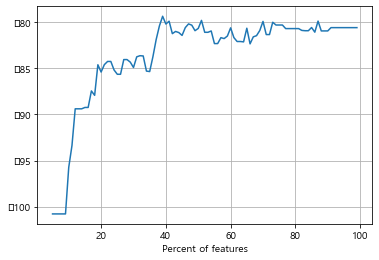

In [43]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X1, y1)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y1, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [44]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X1, y1)
X1_select = fs.transform(X1)
target1_select = fs.transform(target1)

In [45]:
print(X1_select.shape)
print(X1.columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 43)
['요일', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '재택근무자_년평균', '재택근무자_년최대', '재택근무자_년최소', '야간근무자_년평균', '출장근무자_년평균', '휴가자_년평균', '야간근무자_일최대', '출장근무자_일최대', '야간근무자_주평균', '출장근무자_주평균', '출장근무자_주최대', '휴가자_주평균', '휴가자_주최대', '재택근무자_요일평균', '재택근무자_요일최대', '야간근무자_요일평균', '야간근무자_요일최대', '야간근무자_요일최소', '출장근무자_요일평균', '출장근무자_요일최대', '출장근무자_요일최소', '휴가자_요일평균', '휴가자_요일최소', '요일_중식계', '요일_석식계', '면 및 만두류', '국(탕)류', '찌개류', '전류', '볶음류', '김치류', '회류', '젓갈류', '음료류', '원재료', '조리_기타', '중식점수']


#### 셀렉션 진행 후 상관관계가 높은 변수를 제외하여 피쳐를 정함

In [49]:
X1 = train_점심[['요일', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '재택근무자_년평균', '재택근무자_년최대', '재택근무자_년최소', '야간근무자_년평균', '출장근무자_년평균', '휴가자_년평균', '야간근무자_일최대', '출장근무자_일최대', '야간근무자_주평균', '출장근무자_주평균', '출장근무자_주최대', '휴가자_주평균', '휴가자_주최대', '재택근무자_요일평균', '재택근무자_요일최대', '야간근무자_요일평균', '야간근무자_요일최대', '야간근무자_요일최소', '출장근무자_요일평균', '출장근무자_요일최대', '출장근무자_요일최소', '휴가자_요일평균', '휴가자_요일최소', '요일_중식계', '요일_석식계', '면 및 만두류', '국(탕)류', '찌개류', '전류', '볶음류', '김치류', '회류', '젓갈류', '음료류', '원재료', '조리_기타', '중식점수']]
y1 = train.중식계
target1 = test_점심[X1.columns]

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:38<00:00,  2.46it/s]

(71, -56.66545518016203)


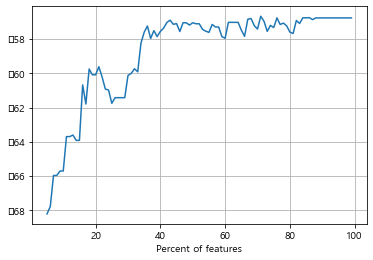

In [46]:
# 사용할 모델 설정 (속도가 빠른 모델 사용 권장)
model = LGBMRegressor(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X2, y2)    #SelectPercentile: 지정된 비율만큼 특성을 선택한다.
    cv_score = cross_val_score(model, X_new, y2, scoring='neg_mean_absolute_error', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [51]:
# 과적합을 피하기 위해 최적의 p값 주변의 값을 선택하는게 더 나은 결과를 얻을 수 있다. 
fs = SelectPercentile(percentile=best_score[0]).fit(X2, y2)
X2_select = fs.transform(X2)
target2_select = fs.transform(target2)

In [52]:
print(X2_select.shape)
print(X2.columns[fs.get_support()].tolist()) #get_support: 선택한 특성을 불린값으로 보여줘서 어떤 특성을 선택했는지 알 수 있다.

(1205, 79)
['요일', '년', '월', '주', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '재택근무자_년평균', '재택근무자_년최대', '재택근무자_년최소', '야간근무자_년평균', '야간근무자_년최대', '출장근무자_년평균', '출장근무자_년최대', '출장근무자_년최소', '휴가자_년평균', '휴가자_년최대', '휴가자_년최소', '재택근무자_월평균', '야간근무자_월평균', '야간근무자_월최대', '출장근무자_월최대', '휴가자_월평균', '휴가자_월최대', '휴가자_월최소', '재택근무자_일평균', '야간근무자_일평균', '야간근무자_일최대', '출장근무자_일최소', '휴가자_일최소', '재택근무자_주평균', '야간근무자_주평균', '야간근무자_주최대', '휴가자_주평균', '휴가자_주최대', '휴가자_주최소', '재택근무자_요일평균', '재택근무자_요일최대', '야간근무자_요일평균', '야간근무자_요일최대', '야간근무자_요일최소', '출장근무자_요일평균', '출장근무자_요일최대', '출장근무자_요일최소', '휴가자_요일평균', '휴가자_요일최대', '휴가자_요일최소', '재택근무자_계절평균', '재택근무자_계절최대', '야간근무자_계절평균', '야간근무자_계절최대', '출장근무자_계절평균', '출장근무자_계절최대', '출장근무자_계절최소', '휴가자_계절평균', '휴가자_계절최대', '휴가자_계절최소', '요일_중식계', '요일_석식계', '계절_중식계', '계절_석식계', '밥류', '국(탕)류', '찌개류', '찜류', '구이류', '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '장류', '우유 및 유제품류', '떡류', '원재료', '석식점수']


#### 셀렉션 진행 후 상관관계가 높은 변수를 제외하여 피쳐를 정함

In [53]:
X2 = train_저녁[['요일', '년', '월', '주', '출근', '휴가비율', '출장비율', '야근비율', '재택비율', '재택근무자_년평균', '재택근무자_년최대', '재택근무자_년최소', '야간근무자_년평균', '야간근무자_년최대', '출장근무자_년평균', '출장근무자_년최대', '출장근무자_년최소', '휴가자_년평균', '휴가자_년최대', '휴가자_년최소', '재택근무자_월평균', '야간근무자_월평균', '야간근무자_월최대', '출장근무자_월최대', '휴가자_월평균', '휴가자_월최대', '휴가자_월최소', '재택근무자_일평균', '야간근무자_일평균', '야간근무자_일최대', '출장근무자_일최소', '휴가자_일최소', '재택근무자_주평균', '야간근무자_주평균', '야간근무자_주최대', '휴가자_주평균', '휴가자_주최대', '휴가자_주최소', '재택근무자_요일평균', '재택근무자_요일최대', '야간근무자_요일평균', '야간근무자_요일최대', '야간근무자_요일최소', '출장근무자_요일평균', '출장근무자_요일최대', '출장근무자_요일최소', '휴가자_요일평균', '휴가자_요일최대', '휴가자_요일최소', '재택근무자_계절평균', '재택근무자_계절최대', '야간근무자_계절평균', '야간근무자_계절최대', '출장근무자_계절평균', '출장근무자_계절최대', '출장근무자_계절최소', '휴가자_계절평균', '휴가자_계절최대', '휴가자_계절최소', '요일_중식계', '요일_석식계', '계절_중식계', '계절_석식계', '밥류', '국(탕)류', '찌개류', '찜류', '구이류', '전류', '볶음류', '조림류', '튀김류', '무침류', '김치류', '장류', '우유 및 유제품류', '떡류', '원재료', '석식점수']]
y2 = train.석식계
target2 = test_저녁[X2.columns]

***

## Modeling

In [54]:
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from ngboost import NGBRegressor

### LGBM

#### 중식

In [55]:
kf = KFold(n_splits = 15, random_state = 607, shuffle = True)

In [56]:
lgbm = LGBMRegressor(random_state = 607, max_depth = 4, n_estimators = 20000, learning_rate = .01)

In [57]:
lgbm_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = lgbm.predict(target1) / 15
    lgbm_pred_1 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 39.0524	training's l2: 2663.5	valid_1's l1: 62.2652	valid_1's l2: 6673.96
Early stopping, best iteration is:
[1539]	training's l1: 42.8359	training's l2: 3218.45	valid_1's l1: 61.5201	valid_1's l2: 6702.38
FOLD MAE = 61.52006182022204
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 37.426	training's l2: 2467.98	valid_1's l1: 59.2325	valid_1's l2: 5809.28
Early stopping, best iteration is:
[1503]	training's l1: 41.6575	training's l2: 3066.61	valid_1's l1: 58.9235	valid_1's l2: 5749.6
FOLD MAE = 58.92346366696711
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 38.3687	training's l2: 2586.53	valid_1's l1: 74.3732	valid_1's l2: 10136.7
Early stopping, best iteration is:
[1605]	training's l1: 40.901	training's l2: 2943.6	valid_1's l1: 74.5094	valid_1's l2: 10071.9
FOLD MAE = 74.50940711251782
Training until validation scores don't imp

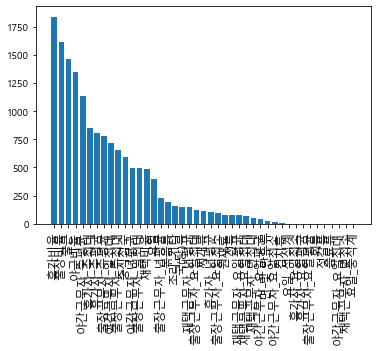

In [59]:
a=pd.DataFrame(data=lgbm.feature_importances_,index=X1.columns)
a=a.sort_values(by=0,ascending=False)
a.columns=['value']

plt.bar(a.index, a.value)
plt.xticks(fontsize=12, rotation='vertical') 
plt.show()

#### 석식

In [60]:
lgbm_pred_2 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)], eval_metric = 'mean_absolute_error', early_stopping_rounds = 2000, verbose = 2000)
    pred = lgbm.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    print(f'FOLD MAE = {mae}')
    mae_list.append(mae)
    sub_pred = lgbm.predict(target2) / 15
    lgbm_pred_2 += sub_pred
print(f'\n{lgbm.__class__.__name__} MAE = {np.mean(mae_list)}')

Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 24.1249	training's l2: 1113.51	valid_1's l1: 50.8954	valid_1's l2: 5019.18
Early stopping, best iteration is:
[1232]	training's l1: 28.8751	training's l2: 1595.2	valid_1's l1: 50.6795	valid_1's l2: 4898
FOLD MAE = 50.679493231575975
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 22.8621	training's l2: 912.924	valid_1's l1: 51.8244	valid_1's l2: 8097.56
Early stopping, best iteration is:
[1208]	training's l1: 28.1868	training's l2: 1406.83	valid_1's l1: 51.1363	valid_1's l2: 7961.77
FOLD MAE = 51.13626095817595
Training until validation scores don't improve for 2000 rounds
[2000]	training's l1: 23.9261	training's l2: 1043.72	valid_1's l1: 50.5497	valid_1's l2: 5187.06
[4000]	training's l1: 18.2643	training's l2: 594.396	valid_1's l1: 49.5709	valid_1's l2: 5239.91
Early stopping, best iteration is:
[2787]	training's l1: 21.2154	training's l2: 806.142	valid_1's l1: 49

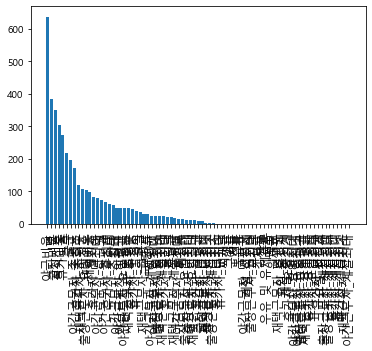

In [62]:
a=pd.DataFrame(data=lgbm.feature_importances_,index=X2.columns)
a=a.sort_values(by=0,ascending=False)
a.columns=['value']

plt.bar(a.index, a.value)
plt.xticks(fontsize=12, rotation='vertical') 
plt.show()

In [64]:
submission['중식계'] = lgbm_pred_1
submission['석식계'] = lgbm_pred_2

In [66]:
submission.to_csv('lgbm_08.csv', index = False)

### NGB

#### 중식

In [67]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

In [68]:
ngb_pred_1 = np.zeros((target1.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X1):
    tr_x, val_x = X1.iloc[tr_idx], X1.iloc[val_idx]
    tr_y, val_y = y1.iloc[tr_idx], y1.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target1) / 15
    ngb_pred_1 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 62.02856843411788
FOLD MAE = 42.0771724368723
FOLD MAE = 37.876487946148565
FOLD MAE = 34.56435533758038
FOLD MAE = 31.439926324938337
FOLD MAE = 29.639203217666044
FOLD MAE = 25.654118910604996
FOLD MAE = 29.403258562450638
FOLD MAE = 21.789496860883094
FOLD MAE = 24.82518586377185
FOLD MAE = 25.412493320655052
FOLD MAE = 22.24819031605616
FOLD MAE = 23.41051075860916
FOLD MAE = 20.72201775107469
FOLD MAE = 18.397728287508905

NGBRegressor MAE = 29.965914288595872


#### 석식

In [70]:
ngb = NGBRegressor(n_estimators = 15000, verbose = 0, random_state = 607)

In [71]:
ngb_pred_2 = np.zeros((target2.shape[0]))
mae_list = []
for tr_idx, val_idx in kf.split(X2):
    tr_x, val_x = X2.iloc[tr_idx], X2.iloc[val_idx]
    tr_y, val_y = y2.iloc[tr_idx], y2.iloc[val_idx]
    ngb.fit(tr_x, tr_y, val_x, val_y, early_stopping_rounds = 2000)
    pred = ngb.predict(val_x)
    mae = mean_absolute_error(val_y, pred)
    mae_list.append(mae)
    print(f'FOLD MAE = {mae}')
    sub_pred = ngb.predict(target2) / 15
    ngb_pred_2 += sub_pred
print(f'\n{ngb.__class__.__name__} MAE = {np.mean(mae_list)}')

FOLD MAE = 49.67898723282697
FOLD MAE = 26.210698660275128
FOLD MAE = 23.166593644974718
FOLD MAE = 18.111956657521986
FOLD MAE = 18.912338214326763
FOLD MAE = 19.628239023225284
FOLD MAE = 18.90783257858593
FOLD MAE = 15.407114119003129
FOLD MAE = 16.316514926258613
FOLD MAE = 17.32365636717872
FOLD MAE = 13.02013722398431
FOLD MAE = 13.708105744324218
FOLD MAE = 14.085017037509733
FOLD MAE = 15.882781524228449
FOLD MAE = 11.766280077025675

NGBRegressor MAE = 19.47508353541664


In [73]:
submission['중식계'] = ngb_pred_1
submission['석식계'] = ngb_pred_2

In [74]:
submission.to_csv('nbg_08.csv', index = False)

### 앙상블

In [75]:
nbg=pd.read_csv('nbg_08.csv')
lgbm=pd.read_csv('lgbm_08.csv')

ensemble=nbg.copy()
ensemble['중식계']=nbg['중식계']*0.5+lgbm['중식계']*0.5
ensemble['석식계']=nbg['석식계']*0.5+lgbm['석식계']*0.5

### 2번째 서브미션

In [84]:
ensemble.to_csv('ensemble_08.csv', index = False)